# Analysis Tools Examples

**Description:** Introduction to generating science performance diagnostic plots and metrics with the [analysis_tools](https://github.com/lsst/analysis_tools) package using a small test dataset from HSC.

**Contact authors:** Nate Lust, Keith Bechtol

**Last verified to run:** 2022-08-09

**LSST Science Piplines version:** Weekly 2022_31

**Container size:** medium

**Targeted learning level:** intermediate

**Skills:** 
* Generate a science performance diagnostic plot and corresponding metric values interactively in a notebook and as part of a pipeline (simple pipeline executor). 
* Adjust the configuration used to produce these diagnostics. 
* Retrieve persisted plots and metrics with the Bulter. 
* Reconstitute input data products that were used to create plots and metrics for further investigation.

## Preliminaries

In [1]:
# Basic imports
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from pprint import pprint

### Getting set up at USDF

See documentation at
* https://developer.lsst.io/usdf/lsst-login.html
* https://developer.lsst.io/usdf/onboarding.html

### Processing rc2_subset

[rc2_subset](https://github.com/lsst-dm/rc2_subset) is a small dataset with just enough Hyper Suprime-Cam (HSC) exposures to compute a set of meaningful science performance metrics.

The LSST Science Pipelines [Getting Started tutorial](https://pipelines.lsst.io/#getting-started) provides a guided tour of data processing using rc2_subset as an example.

For convenience, there is a shell script `process_rc2_subset.sh` in the same directory as this notebook that shows the commands to process rc2_subset on the USDF.

### Setting up the analysis_tools package

Check the version of the stack you are using

In [2]:
!eups list -s | grep lsst_distrib

lsst_distrib          g0b29ad24fb+cafeaf151e 	current w_2022_32 setup


The `analysis_tools` package was added to `lsst_distrib` in August 2022, and accordingly, if you have set up the LSST Stack version `w_2022_32` or later, then you should be able to import `analysis_tools` directly in the notebook.

In [3]:
import lsst.analysis.tools
print(lsst.analysis.tools.__file__)

/home/d/dagoret/repos/repos_w_2022_32/analysis_tools/python/lsst/analysis/tools/__init__.py


If you are doing development on the `analysis_tools` package and want to test in a notebook, follow the guidance [here](https://nb.lsst.io/science-pipelines/development-tutorial.html). Brief version below (for work on the RSP at USDF):

1. In the termal, clone the [analysis_tools](https://github.com/lsst/analysis_tools) repo and set up the package

```
source /opt/lsst/software/stack/loadLSST.bash
setup lsst_distrib

# Choose file location for your repo
cd ~/repos/
git clone https://github.com/lsst/analysis_tools.git
cd analysis_tools
setup -k -r .
scons
```

2. Add the following line to `~/notebooks/.user_setups`

```
setup -k -r ~/repos/analysis_tools
```

Your local version of `analysis_tools` should now be accessible in a notebook.

## Generating consistent metric values and visualizations

### Load data for testing

In [4]:
!ls /sdf/group/rubin/u/dagoret/test1_20220811/rc2_subset/SMALL_HSC

butler.yaml  gen3.sqlite3  HSC	refcats  skymaps  u


In [5]:
from lsst.daf.butler import Butler

#repo = "/project/sandbox/bechtol/rc2_subset/SMALL_HSC"
#collection = "u/bechtol/step3"


repo = "/sdf/group/rubin/u/dagoret/test1_20220811/rc2_subset/SMALL_HSC"
collection = "u/dagoret/step3"

butler = Butler(repo, collections=[collection])
registry = butler.registry

In [6]:
# Display the available dataset types
for d in sorted(registry.queryDatasetTypes()): print(d.name)

AB1_config
AB1_log
AB1_metadata
AD1_design_config
AD1_design_log
AD1_design_metadata
AD2_design_config
AD2_design_log
AD2_design_metadata
AD3_design_config
AD3_design_log
AD3_design_metadata
AF1_design_config
AF1_design_log
AF1_design_metadata
AF2_design_config
AF2_design_log
AF2_design_metadata
AF3_design_config
AF3_design_log
AF3_design_metadata
AM1_config
AM1_log
AM1_metadata
AM2_config
AM2_log
AM2_metadata
AM3_config
AM3_log
AM3_metadata
PA1_config
PA1_log
PA1_metadata
PF1_design_config
PF1_design_log
PF1_design_metadata
TE3_config
TE3_log
TE3_metadata
TE4_config
TE4_log
TE4_metadata
analyzeObjectTableCore_config
analyzeObjectTableCore_log
analyzeObjectTableCore_metadata
assembleCoadd_config
assembleCoadd_log
assembleCoadd_metadata
bfKernel
bias
brightObjectMask
calexp
calexpBackground
calexp_camera
calibrate_config
calibrate_log
calibrate_metadata
camera
catalogMatchTract_config
catalogMatchTract_log
catalogMatchTract_metadata
characterizeImage_config
characterizeImage_log
charact

In [7]:
# There should be one objectTable_tract catalog available
sorted(registry.queryDatasets("objectTable_tract"))

[DatasetRef(DatasetType('objectTable_tract', {skymap, tract}, DataFrame), {skymap: 'hsc_rings_v1', tract: 9813}, id=0eefb9c4-643e-47ce-9280-5f14f00cf7ef, run='u/dagoret/step3/20220811T222415Z')]

In [8]:
dataId = {"tract": 9813, "instrument": "hsc"}
objectTable = butler.get("objectTable_tract", dataId=dataId)
objectTable

column,yErr,ebv,detect_fromBlend,sky_object,xErr,detect_isDeblendedSource,deblend_nChild,refExtendedness,detect_isIsolated,shape_yy,...,g_kronFlux_flag,g_kronFlux_flag_bad_radius,g_kronFlux_flag_bad_shape,g_kronFlux_flag_bad_shape_no_psf,g_kronFlux_flag_edge,g_kronFlux_flag_no_fallback_radius,g_kronFlux_flag_no_minimum_radius,g_kronFlux_flag_small_radius,g_kronFlux_flag_used_minimum_radius,g_kronFlux_flag_used_psf_radius
objectId,,,,,,,,,,,,,,,,,,,,,
3495976385350991873,NaN,0.016590,False,False,NaN,True,1,NaN,True,4.737723,...,True,False,True,False,True,False,False,False,False,False
3495976385350991874,0.039593,0.016336,False,False,0.044172,False,3,1.0,False,3.564461,...,False,False,False,False,False,False,False,False,False,False
3495976385350991875,NaN,0.016331,False,False,NaN,True,1,NaN,True,1.620860,...,True,False,True,False,True,False,False,False,False,False
3495976385350991876,NaN,0.016222,False,False,NaN,False,3,NaN,False,7.238082,...,True,False,True,False,True,False,False,False,False,False
3495976385350991877,NaN,0.016201,False,False,NaN,True,1,NaN,True,1.951498,...,True,False,True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495967589257999447,1.100333,0.016220,False,False,1.624227,False,0,0.0,True,NaN,...,True,True,True,False,False,False,False,True,False,True
3495967589257999448,1.101892,0.018730,False,False,1.294657,False,0,1.0,True,NaN,...,True,False,True,False,False,False,False,False,False,False
3495967589257999449,0.374309,0.016180,False,False,0.489303,False,0,1.0,True,4.697563,...,False,False,False,False,False,False,False,False,False,False


In [9]:
# Show the column names
objectTable.columns.values

array(['yErr', 'ebv', 'detect_fromBlend', 'sky_object', 'xErr',
       'detect_isDeblendedSource', 'deblend_nChild', 'refExtendedness',
       'detect_isIsolated', 'shape_yy', 'refBand',
       'detect_isDeblendedModelSource', 'xy_flag', 'refFwhm', 'shape_xy',
       'coord_dec', 'footprintArea', 'shape_flag', 'deblend_skipped',
       'merge_peak_sky', 'detect_isTractInner', 'detect_isPatchInner',
       'y', 'coord_ra', 'shape_xx', 'parentObjectId', 'x',
       'detect_isPrimary', 'tract', 'patch', 'y_ra', 'y_decl',
       'y_psfFlux', 'y_psfFluxErr', 'y_free_psfFlux', 'y_free_psfFluxErr',
       'y_free_psfFlux_flag', 'y_bdE1', 'y_bdE2', 'y_bdReB', 'y_bdReD',
       'y_bdChi2', 'y_bdFluxB', 'y_bdFluxBErr', 'y_bdFluxD',
       'y_bdFluxDErr', 'y_gaapPsfFlux', 'y_gaapPsfFluxErr',
       'y_gaap0p5Flux', 'y_gaap0p5FluxErr', 'y_gaap0p7Flux',
       'y_gaap0p7FluxErr', 'y_gaap1p0Flux', 'y_gaap1p0FluxErr',
       'y_gaap1p5Flux', 'y_gaap1p5FluxErr', 'y_gaap2p5Flux',
       'y_gaap2p5FluxE

### Generate a metric

* Instantiate a butler, load some data
* Pass loaded data to an `AnalysisMetric` to compute metric values

In this example, we compute PSF model size residuals relative to the observed PSF size.

In [10]:
from lsst.analysis.tools.analysisMetrics import ShapeSizeFractionalMetric
from lsst.analysis.tools.tasks.base import _StandinPlotInfo

In [11]:
metric = ShapeSizeFractionalMetric()

In [12]:
results = metric(objectTable, band='i')

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [13]:
results

{'i_highSNStars_median': Measurement('i_highSNStars_median', <Quantity nan pix>),
 'i_highSNStars_sigmaMad': Measurement('i_highSNStars_sigmaMad', <Quantity nan pix>),
 'i_highSNStars_count': Measurement('i_highSNStars_count', <Quantity 0. ct>),
 'i_lowSNStars_median': Measurement('i_lowSNStars_median', <Quantity 0.00021203 pix>),
 'i_lowSNStars_sigmaMad': Measurement('i_lowSNStars_sigmaMad', <Quantity 0.00472002 pix>),
 'i_lowSNStars_count': Measurement('i_lowSNStars_count', <Quantity 227. ct>)}

### Generate a plot

* Use same data from example above
* Pass data to an analysis_tool to generate a plot and visualize in notebook
* Confirm that displayed values are consistent

In [14]:
from lsst.analysis.tools.analysisPlots import ShapeSizeFractionalDiffScatterPlot

In [15]:
plot = ShapeSizeFractionalDiffScatterPlot()
# set some configs, we will go into this later
plot.produce.addSummaryPlot = False

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


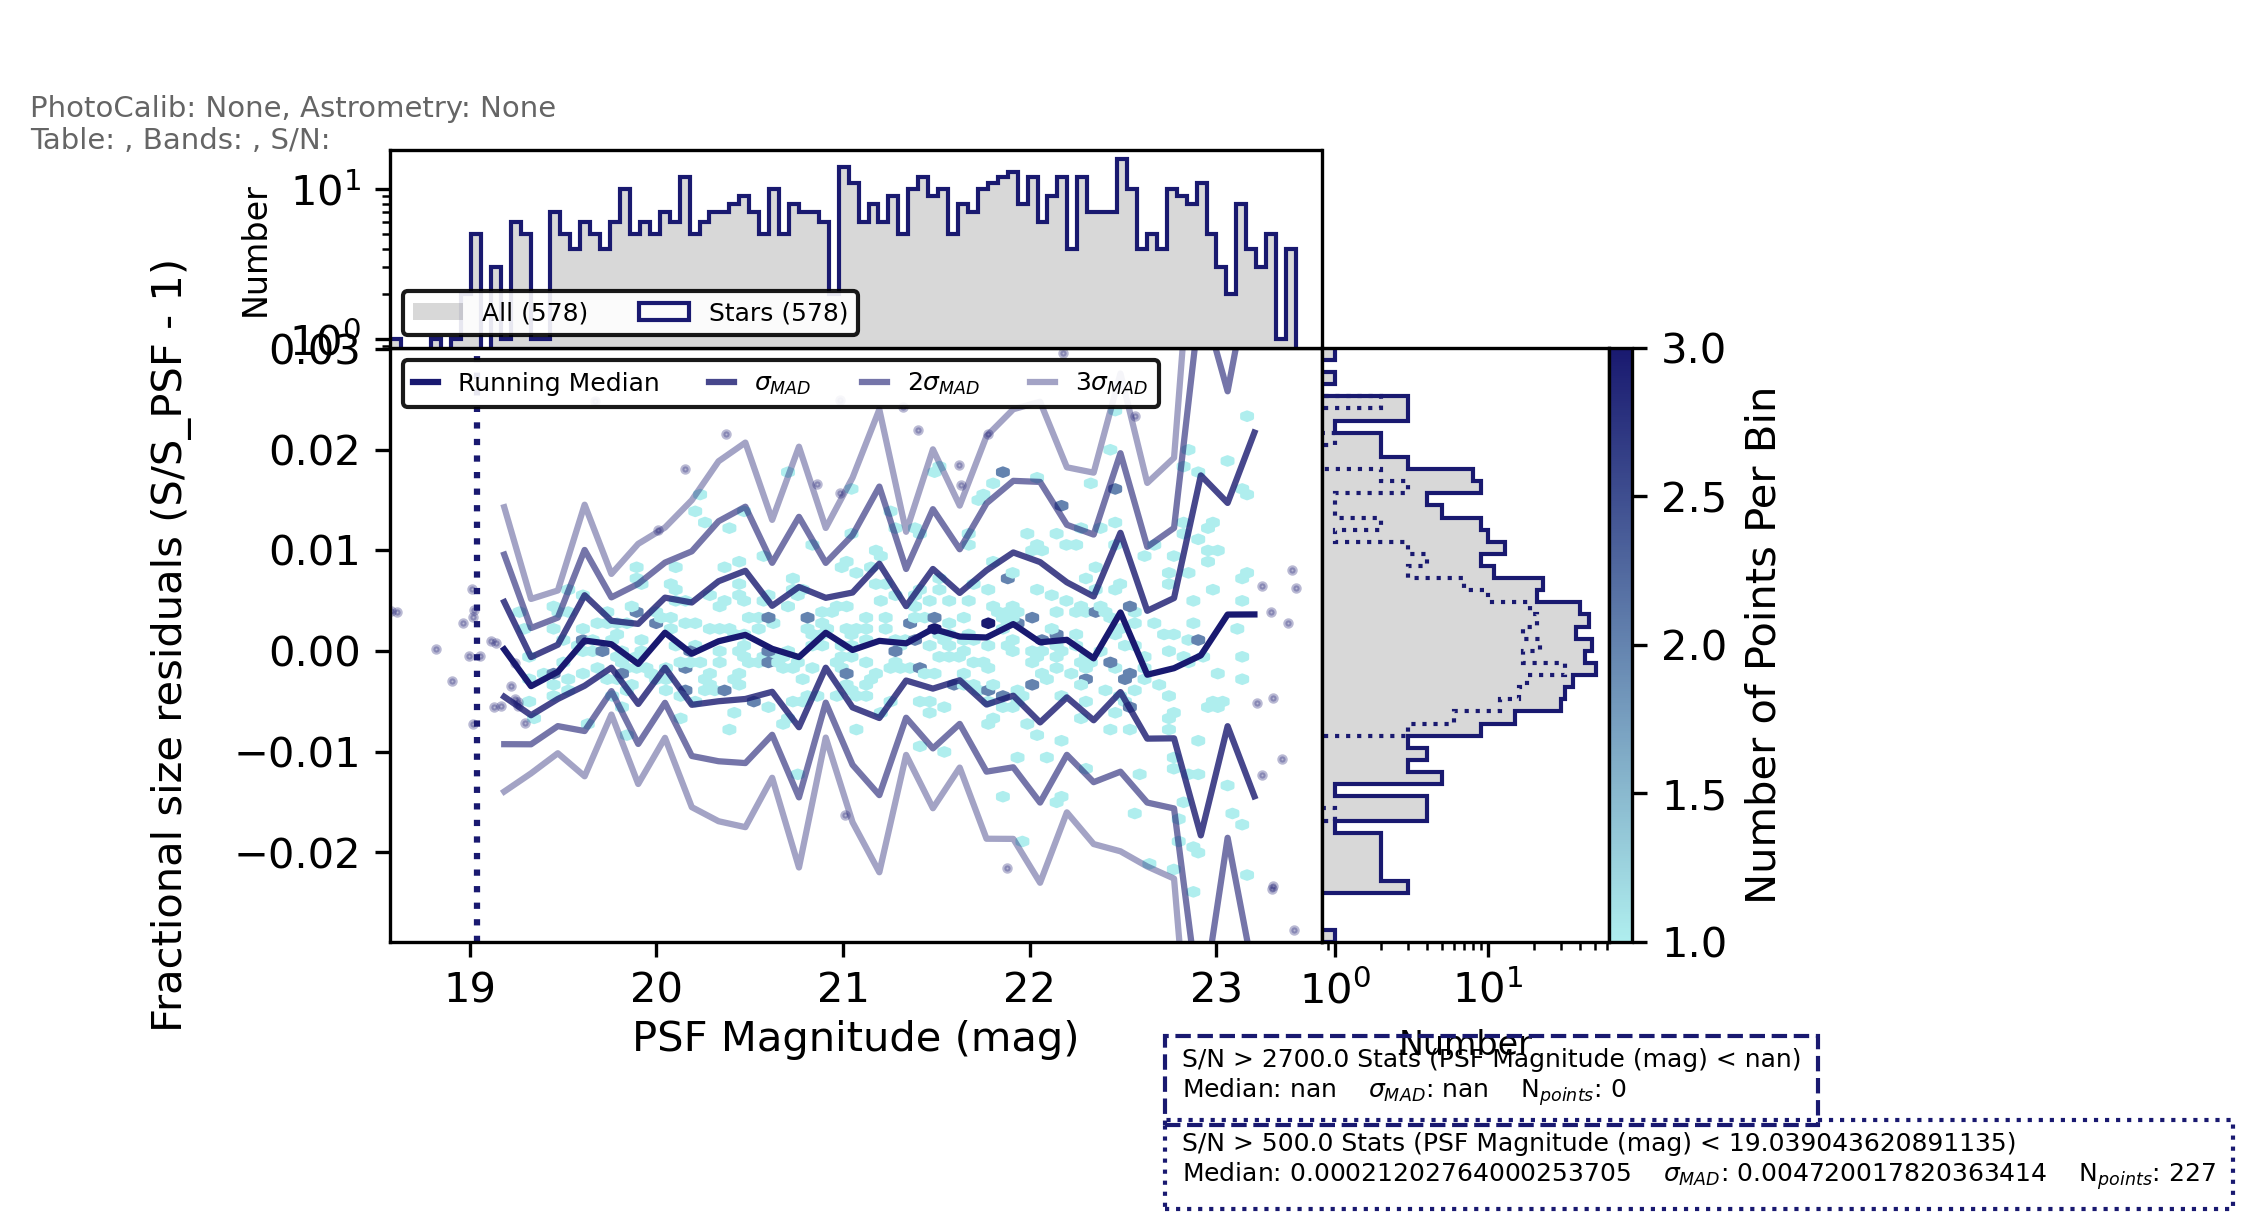

In [16]:
# later keyword arguments will not be required going forward
results = plot(objectTable, band='i', skymap=None, plotInfo=_StandinPlotInfo())

## How it works 

### Terminology

Data Types
* Scalar - Something that is number like (int, float, numpy.float32 etc.)
* Vector - Something that is ndarray like
* KeyedData - Anything that is indexed by a string that can return a Vector, or Scalar

Analysis Structures
* ConfigurableAction - generic interface for function like objects (actions) that have state which can be set during configuration
* AnalysisAction - A ConfigurableAction subclass that is specialized for actions that function in analysis contexts
* AnalysisTool - A top level "container" of multiple AnalysisActions which performs one type of analysis

Below we dive into the later two in more detail

### Using AnalysisActions

* These are the atomic bits of analysis_tools; They can be combined together to make more complex actions, or used as part of an AnalysisTool
* Show some examples of using configurable actions like standalone functions. This is intended to provide users with more intution about how configurable actions work.
* Examples with KeyedDataActions, VectorActions (including selectors), and ScalarActions
* Show examples of configuration

In [17]:
from lsst.analysis.tools.actions.vector import CalcShapeSize, MagColumnNanoJansky

Let's create an example AnalysisAction to compute the measured PSF size for a set of stars from an object catalog.

In [18]:
sizeCalculator = CalcShapeSize()

In [19]:
# Inspect the configuration of this object.
pprint(sizeCalculator.toDict())

{'colXx': '{band}_ixx',
 'colXy': '{band}_ixy',
 'colYy': '{band}_iyy',
 'sizeType': 'determinant'}


In [20]:
# Inspect the required input schema, notice that we will need to provide the band information
sizeCalculator.getInputSchema()

(('{band}_ixx', numpy.ndarray[typing.Any, numpy.dtype[+ScalarType]]),
 ('{band}_iyy', numpy.ndarray[typing.Any, numpy.dtype[+ScalarType]]),
 ('{band}_ixy', numpy.ndarray[typing.Any, numpy.dtype[+ScalarType]]))

In [21]:
size = sizeCalculator(objectTable, band='i')
print(size)

objectId
3495976385350991873    1.669656
3495976385350991874    1.911321
3495976385350991875    1.404734
3495976385350991876    2.363680
3495976385350991877    1.597392
                         ...   
3495967589257999447         NaN
3495967589257999448         NaN
3495967589257999449         NaN
3495967589257999450         NaN
3495967589257999451         NaN
Length: 98332, dtype: float64


In [22]:
# Another example, this time to convert fluxes to magnitudes
mag = MagColumnNanoJansky(vectorKey='{band}_psfFlux')(objectTable, band='i')

# Notice that the line above is equiavalent to the following
mag_alternate = MagColumnNanoJansky(vectorKey='i_psfFlux')(objectTable)

assert np.allclose(mag, mag_alternate, equal_nan=True)

Text(0.5, 1.0, 'size vs mag')

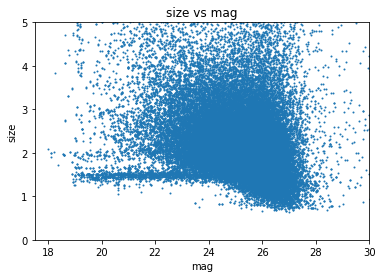

In [23]:
plt.figure()
plt.scatter(mag, size, s=1)
plt.xlim(17.5, 30.)
plt.ylim(0, 5)
plt.xlabel("mag")
plt.ylabel("size")
plt.title("size vs mag")

Let's remake that simple plot now selecting only the stars

In [24]:
from lsst.analysis.tools.actions.vector import StarSelector

In [25]:
star_selection = StarSelector()(objectTable, band='i')

Text(0.5, 1.0, 'size vs mag (star selection)')

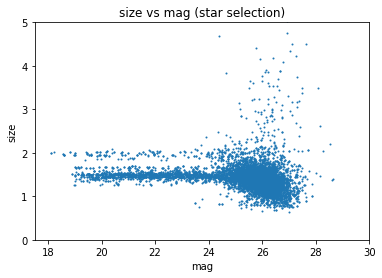

In [26]:
plt.figure()
plt.scatter(mag[star_selection], size.values[star_selection], s=1)
plt.xlim(17.5, 30.)
plt.ylim(0, 5)
plt.xlabel("mag")
plt.ylabel("size")
plt.title("size vs mag (star selection)")

We can also chain together AnalysisActions, as in the following example that produces an equivalent plot. The `analysis_tools` package frequently uses this approach of chaining together AnalysisActions.

Text(0.5, 1.0, 'size vs mag (star selection)')

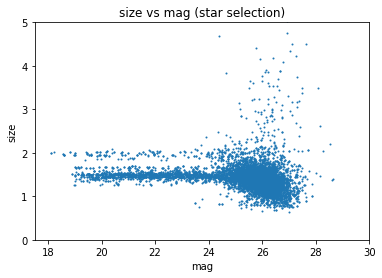

In [27]:
from lsst.analysis.tools.actions.vector import DownselectVector
from lsst.analysis.tools.actions.keyedData import AddComputedVector

band = "i"
objectTable = AddComputedVector(action=CalcShapeSize(), keyName="size")(objectTable, band=band)

# Note type(objectTable) is now a python dictionary instead of a pandas table, but since both
# "quack" like KeyedData so they can be used interchangably

objectTable = AddComputedVector(
    action=MagColumnNanoJansky(vectorKey='{band}_psfFlux'),
    keyName="mag"
)(objectTable, band=band)

size = DownselectVector(vectorKey="size", selector=StarSelector())(objectTable, band=band)
mag = DownselectVector(vectorKey="mag", selector=StarSelector())(objectTable, band=band)

plt.figure()
plt.scatter(mag, size, s=1)
plt.xlim(17.5, 30.)
plt.ylim(0, 5)
plt.xlabel("mag")
plt.ylabel("size")
plt.title("size vs mag (star selection)")

### Generic interface for data
Actions are not restricted to tables or products loaded from the butler, KeyedData could also be things like dictionaries of numpy arrays.

In [28]:
import lsst.analysis.tools.actions
dir(lsst.analysis.tools.actions)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'keyedData',
 'plot',
 'scalar',
 'vector']

In [29]:
from lsst.analysis.tools.actions.scalar import StdevAction

# create some KeyedData
data = {"randomData": np.random.normal(0, 3, 100)}

# initialize an action, setting it to use the key set above
action = StdevAction(vectorKey="randomData")

# Run the action and print the results
print(f"The standard deviation is {action(data)}")

The standard deviation is 2.885315959343594


### Three conceptual steps in an `AnalysisTool`: prep, process, produce

As mentioned AnalysisTools can be thought of as executable containers of AnalysisActions. There are three different AnalysisActions, referred to as stages, named prep, process, and produce.
* Prep - Responsible for any initial selection and filtering of data
* Process - This is where any transformations or derived data should be computed
* Produce - Generates final plot or metric objects

The following examples will:
* Walk through the three stages of running an analysis tool in sequential lines of code, passing the output of one step as input to the next step
* Examine intermediate results

dict_keys(['i_psfFlux', 'i_ixx', 'i_iyy', 'i_ixy', 'i_ixxPSF', 'i_iyyPSF', 'i_ixyPSF', 'i_extendedness', 'patch', 'i_psfFluxErr'])
dict_keys(['mags', 'fracDiff', 'eDiff', 'e1Diff', 'e2Diff', 'starSelector', 'patchWhole', 'xStars', 'psfFlux', 'psfFluxErr', 'patch', 'yStars', 'starsHighSNMask', 'starsLowSNMask', 'i_lowSNStars_median', 'i_lowSNStars_sigmaMad', 'i_lowSNStars_count', 'i_lowSNStars_approxMag', 'i_highSNStars_median', 'i_highSNStars_sigmaMad', 'i_highSNStars_count', 'i_highSNStars_approxMag', 'highSnThreshold', 'lowSnThreshold'])


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


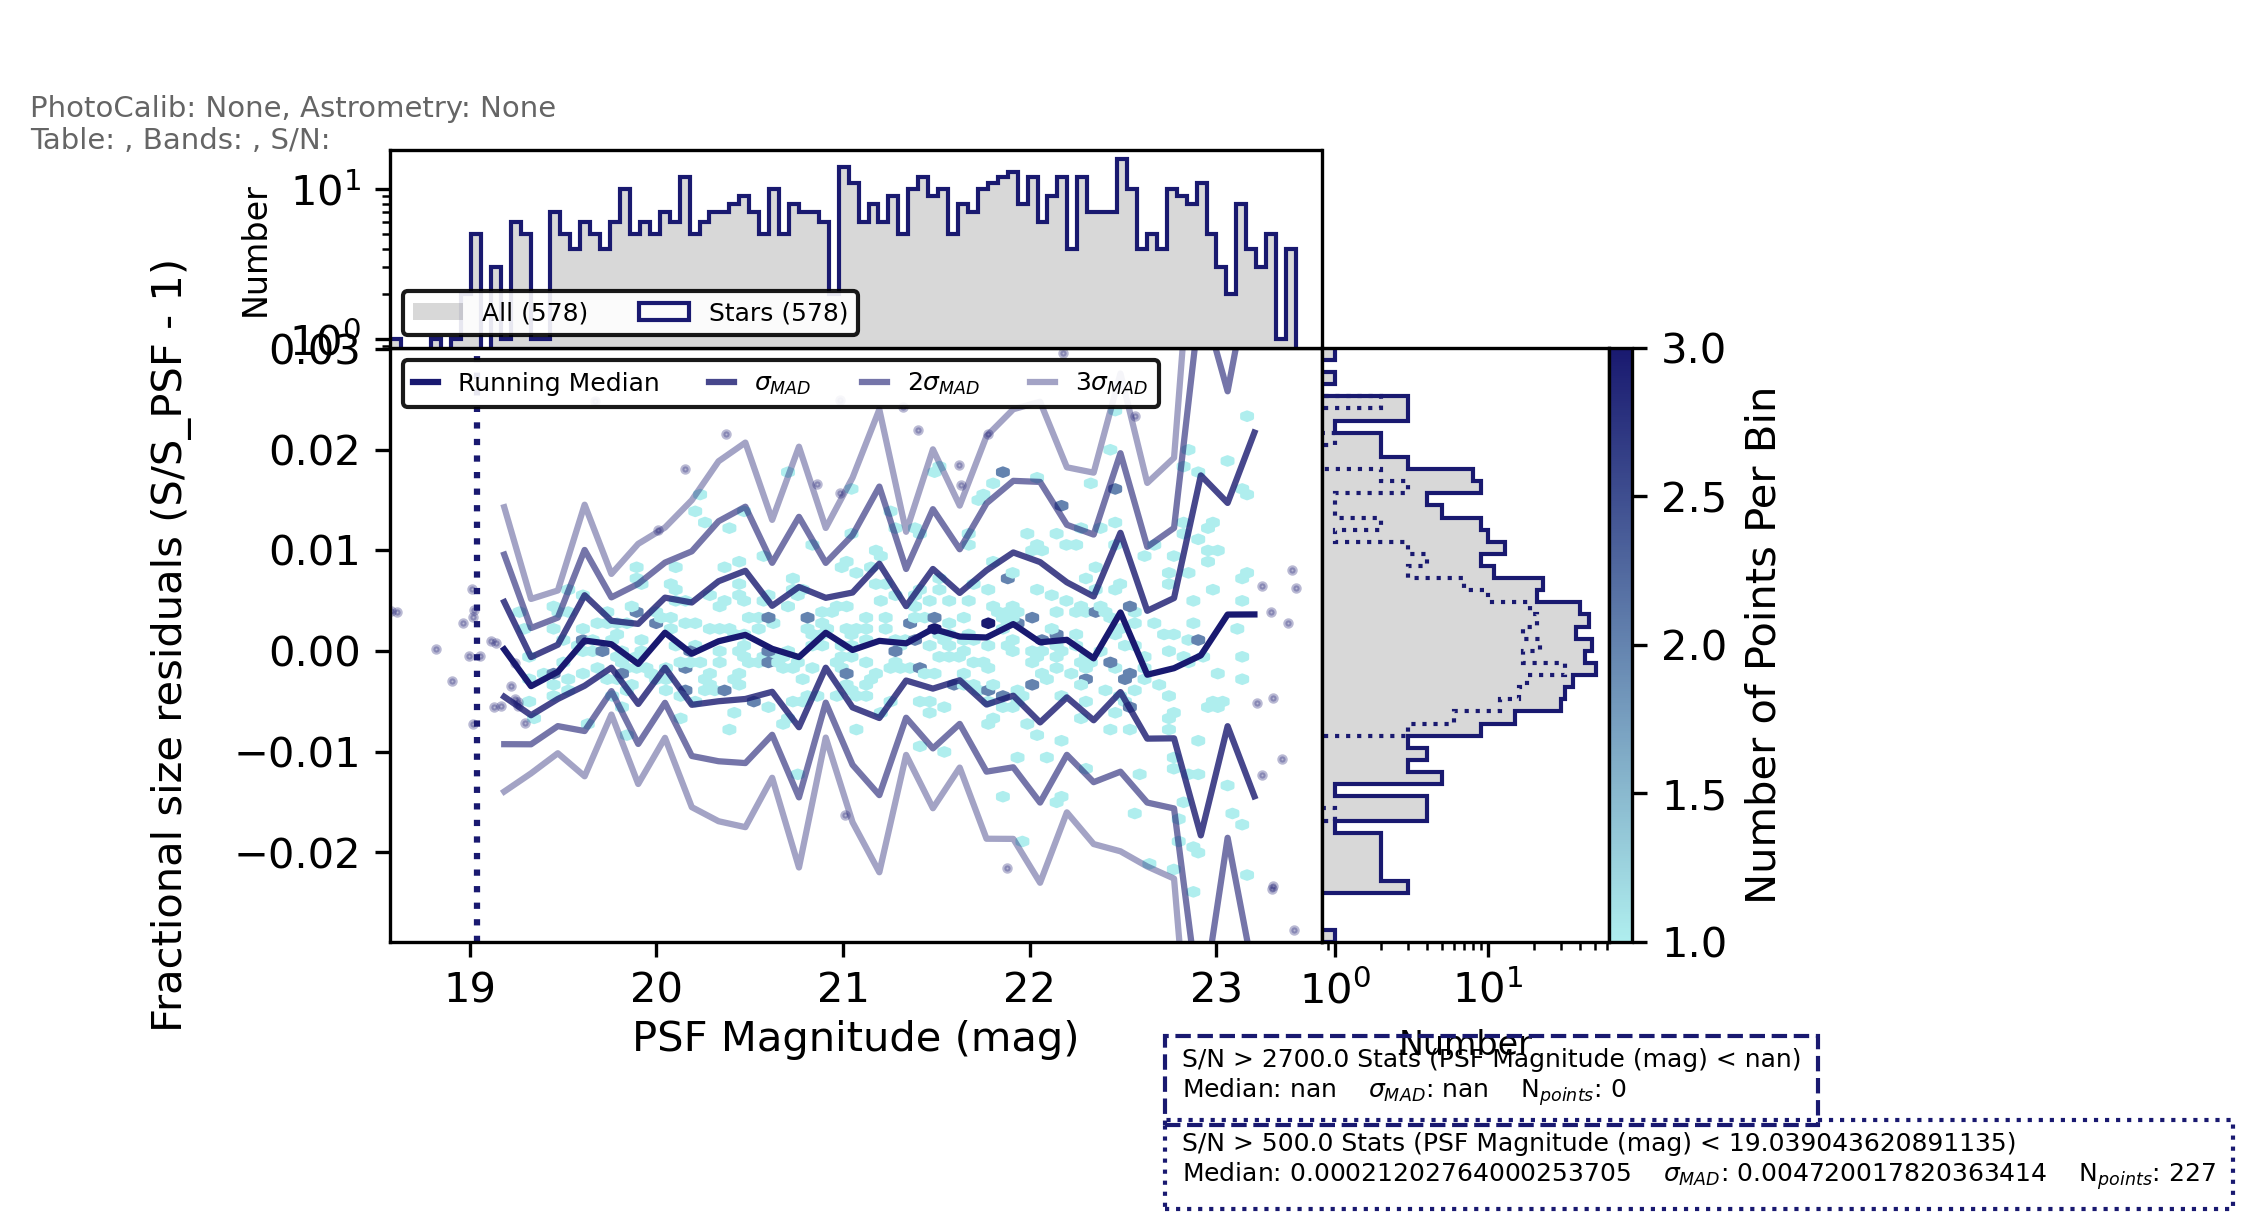

In [30]:
# make a new instance of the AnalysisPlot we used earlier
plot = ShapeSizeFractionalDiffScatterPlot()
plot.produce.addSummaryPlot = False

# This helps simplify some of the configuration
# by setting keys which are needed later to be
# loaded by earlier steps, it happens
# automatically when the AnalysisTool is
# used as a single unit.
plot.populatePrepFromProcess()

# Run the action by stepping through each stage
stage1 = plot.prep(objectTable, band='i')
print(stage1.keys())
stage2 = plot.process(stage1, band='i')
print(stage2.keys())
figure = plot.produce(stage2, band='i', skymap=None, plotInfo=_StandinPlotInfo())


## Workflow examples

### Running analysis_tools as part of a pipeline

* **All examples in this notebook should use the simple pipeline executor** (here is how you do it in a notebook)
* We have a PipelineTask for each data product. A task can run multiple AnalysisTools that each produce a set of plots or set of metrics and are subclasses of AnalysisPipelineTask.
* Discuss an example yaml pipeline file (load the yaml)
* Provide the command to run the pipeline
* Show how to configure the pipeline, e.g., turning on or off different metrics and plots or changing other parameters

## Pipeline
This is a copy of the coaddQualityCore pipeline in analysis_tools, reproduced here for reference
```
description: |
  Tier1 plots and metrics to assess coadd quality
tasks:
  analyzeObjectTableCore:
    class: lsst.analysis.tools.tasks.ObjectTableTractAnalysisTask
    config:
      connections.outputName: objectTableCore
      plots.shapeSizeFractionalDiffScatter: ShapeSizeFractionalDiffScatterPlot
      metrics.shapeSizeFractionalMetric: ShapeSizeFractionalMetric
      plots.e1DiffScatter: E1DiffScatterPlot
      metrics.e1DiffScatterMetric: E1DiffMetric
      plots.e2DiffScatter: E2DiffScatterPlot
      metrics.e2DiffScatterMetric: E2DiffMetric
      metrics.skyFluxStatisticMetric: SkyFluxStatisticMetric
      metrics.skyFluxStatisticMetric.applyContext: CoaddContext
      python: |
        from lsst.analysis.tools.analysisPlots import *
        from lsst.analysis.tools.analysisMetrics import *
        from lsst.analysis.tools.contexts import *
  catalogMatchTract:
    class: lsst.analysis.tools.tasks.catalogMatch.CatalogMatchTask
    config:
      bands: ['u', 'g', 'r', 'i', 'z', 'y']
  refCatObjectTract:
    class: lsst.analysis.tools.tasks.refCatObjectAnalysis.RefCatObjectAnalysisTask
    config:
      bands: ['u', 'g', 'r', 'i', 'z', 'y']
      ```

In [31]:
from lsst.ctrl.mpexec import SimplePipelineExecutor
from lsst.pipe.base import Pipeline

# set up an output collection with your username
#outputCollection = "u/nate2/analysisToolsExample"
outputCollection = "u/dagoret/analysisToolsExample"

# this can be skipped if you already have a read writable butler setup (above is read only)
butlerRW = SimplePipelineExecutor.prep_butler(repo, inputs=[collection], output=outputCollection)

# load in the pipeline to run
pipeline = Pipeline.from_uri("$ANALYSIS_TOOLS_DIR/pipelines/coaddQualityCore.yaml")

# override a configuration within a certain AnalysisTool
configKey = "plots.shapeSizeFractionalDiffScatter.prep.selectors.snSelector.threshold"
pipeline.addConfigOverride("analyzeObjectTableCore", configKey, 400)

bands = ['g', 'r', 'i', 'z']
pipeline.addConfigOverride("analyzeObjectTableCore", "bands", bands)
pipeline.addConfigOverride("catalogMatchTract", "bands", bands)
pipeline.addConfigOverride("refCatObjectTract", "bands", bands)

# restrict processing to the same dataId used above
whereString = "tract = 9813 AND skymap = 'hsc_rings_v1'"

# Prevent the executor from dumping plots into the notebook
backend_ =  mpl.get_backend() 
mpl.use("Agg")

executor = SimplePipelineExecutor.from_pipeline(pipeline, where=whereString, butler=butlerRW)
quanta = executor.run(True)

# Restore the ability for plots to be put into the notebook
mpl.use(backend_)

# If you only want to run one plot in a task in the pipeline do the following prior to execution
pipeline.addConfigOverride("analyzeObjectTableCore", "plots", None)
pipeline.addConfigOverride("analyzeObjectTableCore", "plots", ShapeSizeFractionalDiffScatterPlot)

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0

### Inspect the results

In [32]:
# refresh our read-only butler to see the changes made. (it's generally a
# good idea to work on read-only things)
butler.registry.refresh()

# see what datasets exist; there should now be objectTableCore_metrics
# for d in sorted(butler.registry.queryDatasetTypes()): print(d.name)

# get the metric that was written
refs = sorted(butler.registry.queryDatasets("objectTableCore_metrics", collections=outputCollection))
refs[0].dataId
objectTable_metrics = butler.get("objectTableCore_metrics", dataId=refs[0].dataId, collections=outputCollection)
pprint(objectTable_metrics)

{'e1DiffScatterMetric': [Measurement('g_highSNStars_median', <Quantity 0.00414925 pix>),
                         Measurement('g_highSNStars_sigmaMad', <Quantity 0.00695953 pix>),
                         Measurement('g_highSNStars_count', <Quantity 6. ct>),
                         Measurement('g_lowSNStars_median', <Quantity 0.00033557 pix>),
                         Measurement('g_lowSNStars_sigmaMad', <Quantity 0.00483619 pix>),
                         Measurement('g_lowSNStars_count', <Quantity 155. ct>),
                         Measurement('r_highSNStars_median', <Quantity -0.00197126 pix>),
                         Measurement('r_highSNStars_sigmaMad', <Quantity 0. pix>),
                         Measurement('r_highSNStars_count', <Quantity 1. ct>),
                         Measurement('r_lowSNStars_median', <Quantity 0.00069911 pix>),
                         Measurement('r_lowSNStars_sigmaMad', <Quantity 0.00396235 pix>),
                         Measurement('r_lowSNStars_co

### Reconstruct the inputs to an analysis_tool

Analysis(Tools/Actions) allow the exact state of and AnalysisTools to be saved into the butler when a pipeline is run. This allows a user to 'reconstruct' things as they were when the tools were executed. This aids in debugging and deep diving into the data.

Below is an example of reconstructing one of the tasks that was run in the Pipeline above.

In [33]:
from lsst.analysis.tools.tasks.reconstructor import reconstructAnalysisTools

# Read in just one task
label = "analyzeObjectTableCore"
taskState, inputData = reconstructAnalysisTools(butler, collection=outputCollection, label=label, dataId=dataId, callback=None)
pprint(taskState)
pprint(inputData)

lsst.analysis.tools.tasks.objectTableTractAnalysis.ObjectTableTractAnalysisConfig(saveMetadata=True, saveLogOutput=True, plots={'e1DiffScatter': {'prep': {'vectorKeys': [], 'selectors': {'flagSelector': {'selectWhenFalse': ['{band}_psfFlux_flag', '{band}_pixelFlags_saturatedCenter', '{band}_extendedness_flag', 'xy_flag'], 'selectWhenTrue': ['detect_isPatchInner', 'detect_isDeblendedSource'], 'bands': ['i']}, 'snSelector': {'fluxType': '{band}_psfFlux', 'threshold': 100.0, 'maxSN': 1000000.0, 'uncertaintySuffix': 'Err', 'bands': []}}}, 'process': {'buildActions': {'e1Diff': {'colA': {'colXx': '{band}_ixx', 'colYy': '{band}_iyy', 'colXy': '{band}_ixy', 'ellipticityType': 'chi', 'halvePhaseAngle': False, 'component': None}, 'colB': {'colXx': '{band}_ixxPSF', 'colYy': '{band}_iyyPSF', 'colXy': '{band}_ixyPSF', 'ellipticityType': 'chi', 'halvePhaseAngle': False, 'component': None}, 'halvePhaseAngle': False, 'component': '1'}, 'e2Diff': {'colA': {'colXx': '{band}_ixx', 'colYy': '{band}_iyy',

Notice that we have access to the object table used to produce the diagnostics.

In [34]:
inputData["data"]

column,yErr,ebv,detect_fromBlend,sky_object,xErr,detect_isDeblendedSource,deblend_nChild,refExtendedness,detect_isIsolated,shape_yy,...,g_kronFlux_flag,g_kronFlux_flag_bad_radius,g_kronFlux_flag_bad_shape,g_kronFlux_flag_bad_shape_no_psf,g_kronFlux_flag_edge,g_kronFlux_flag_no_fallback_radius,g_kronFlux_flag_no_minimum_radius,g_kronFlux_flag_small_radius,g_kronFlux_flag_used_minimum_radius,g_kronFlux_flag_used_psf_radius
objectId,,,,,,,,,,,,,,,,,,,,,
3495976385350991873,NaN,0.016590,False,False,NaN,True,1,NaN,True,4.737723,...,True,False,True,False,True,False,False,False,False,False
3495976385350991874,0.039593,0.016336,False,False,0.044172,False,3,1.0,False,3.564461,...,False,False,False,False,False,False,False,False,False,False
3495976385350991875,NaN,0.016331,False,False,NaN,True,1,NaN,True,1.620860,...,True,False,True,False,True,False,False,False,False,False
3495976385350991876,NaN,0.016222,False,False,NaN,False,3,NaN,False,7.238082,...,True,False,True,False,True,False,False,False,False,False
3495976385350991877,NaN,0.016201,False,False,NaN,True,1,NaN,True,1.951498,...,True,False,True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495967589257999447,1.100333,0.016220,False,False,1.624227,False,0,0.0,True,NaN,...,True,True,True,False,False,False,False,True,False,True
3495967589257999448,1.101892,0.018730,False,False,1.294657,False,0,1.0,True,NaN,...,True,False,True,False,False,False,False,False,False,False
3495967589257999449,0.374309,0.016180,False,False,0.489303,False,0,1.0,True,4.697563,...,False,False,False,False,False,False,False,False,False,False


We can now reproduce diagnostic plots.

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-4.1.0/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


AttributeError: 'NoneType' object has no attribute 'generateTract'

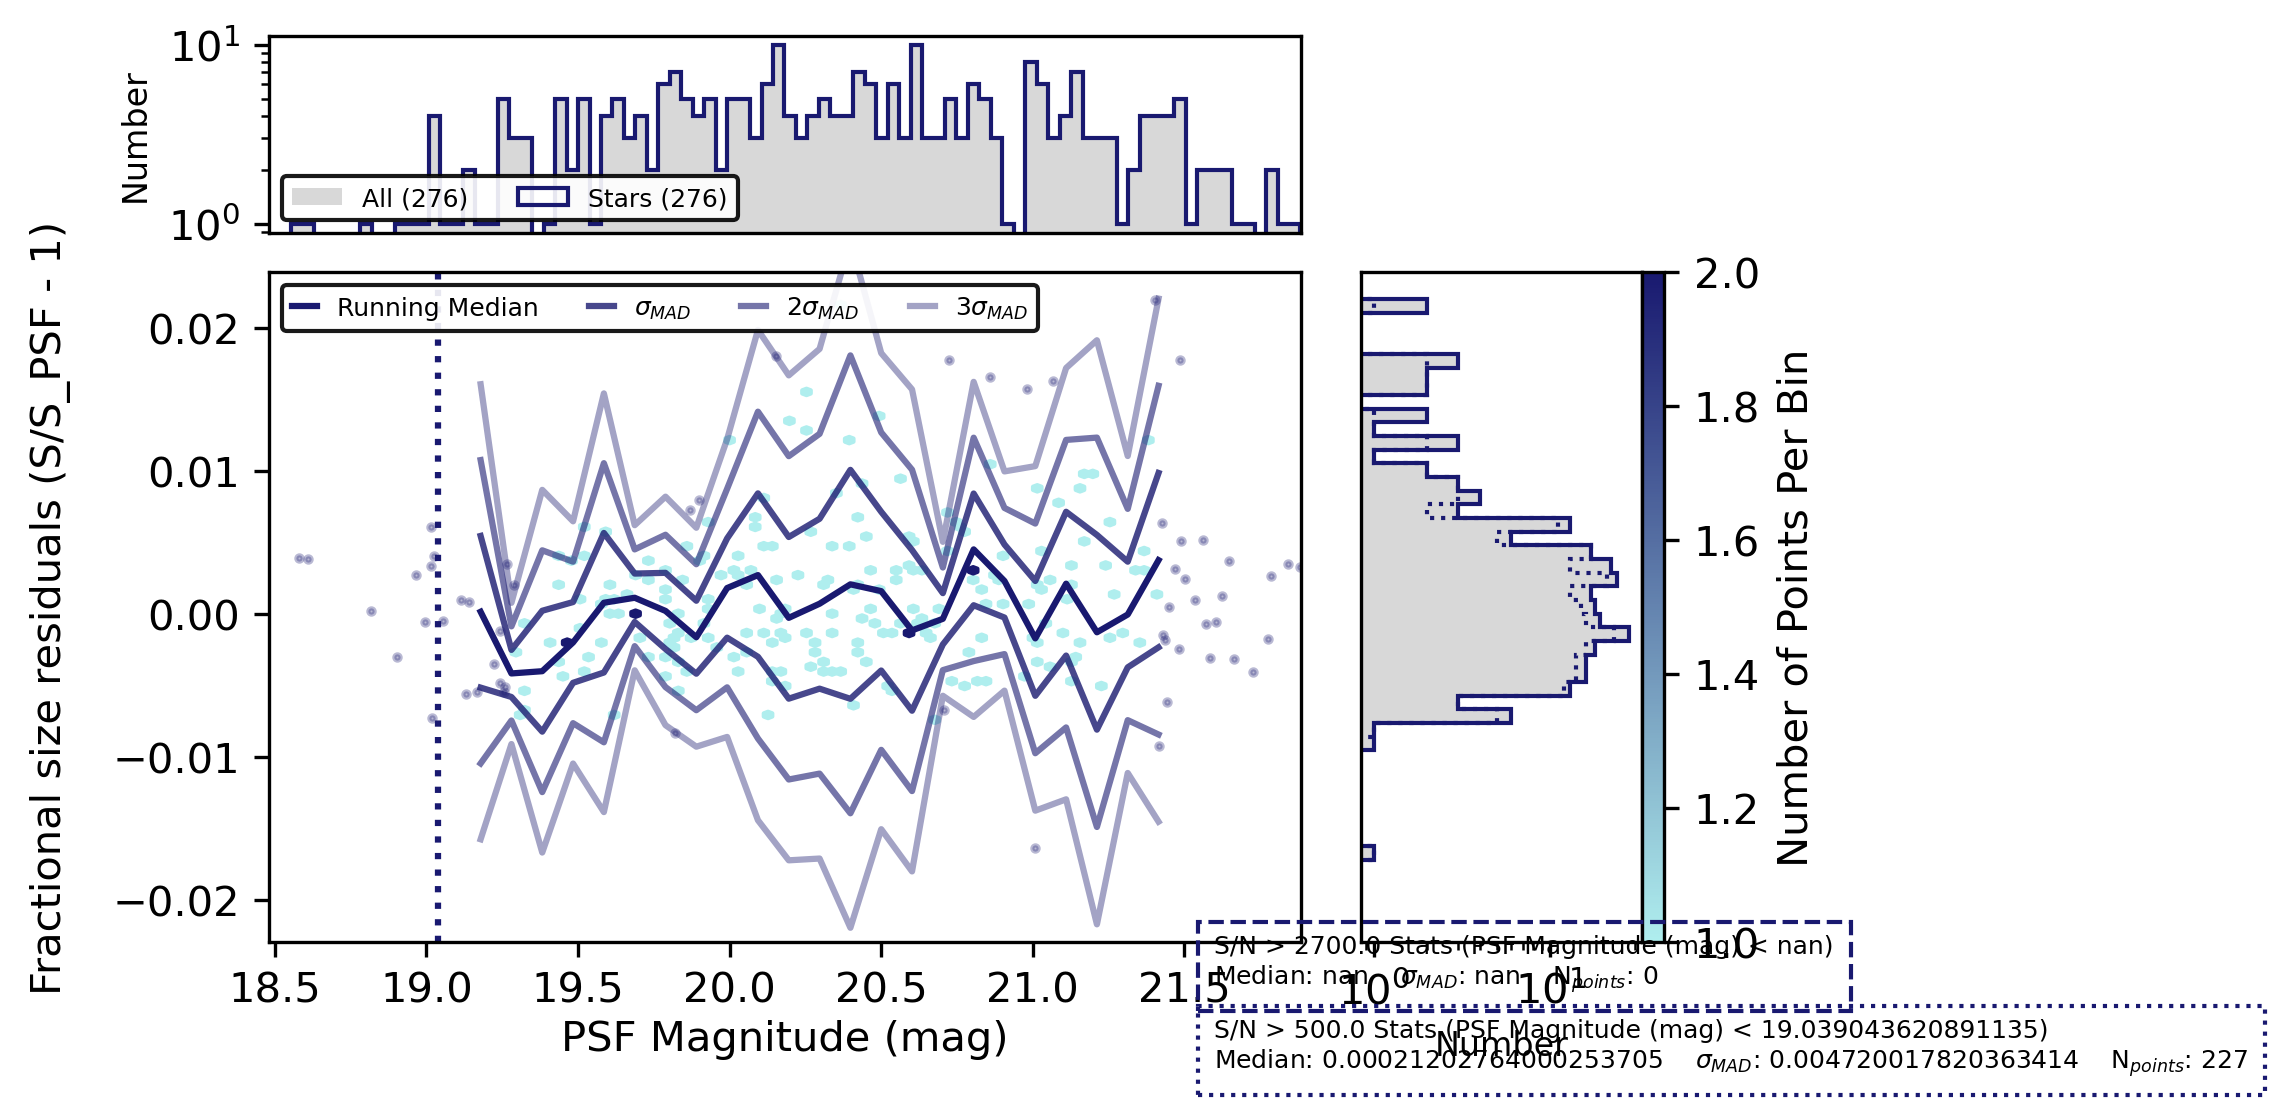

In [35]:
# Rerun one of the plots
taskState.plots.shapeSizeFractionalDiffScatter(
    inputData['data'],
    band='i',
    skymap=None,
    plotInfo=_StandinPlotInfo()
)

# change some configuration to see the differences
taskState.plots.shapeSizeFractionalDiffScatter.prep.selectors.snSelector.threshold = 50
taskState.plots.shapeSizeFractionalDiffScatter(
    inputData['data'],
    band='i',
    skymap=None,
    plotInfo=_StandinPlotInfo()
)

# This could be run in stages like the above example to investigate issues

## Make a custom analysis tool

Let's take a look at what at how a metric is implemented before creating a new AnalysisTool

In [ ]:
# This is copied from lsst.analysis.tools.analysisMetrics.limitingMagnitudeMetric

from lsst.analysis.tools.interfaces import AnalysisMetric

class FiveSigmaPointSourceDepthMetric(AnalysisMetric):
    """Calculate the five-sigma point source depth of a visit, based on the
    PSF flux and its reported error. By default the calculation selects
    objects between 4.75 < S/N < 5.25, but these limits are configurable.
    The flux type to use for selection is also configurable. Both the median
    and mean 5-sigma depths are returned.
    """

    parameterizedBand: bool = False

    def setDefaults(self):
        super().setDefaults()

        self.prep.selectors.starSelector = StarSelector()
        self.prep.selectors.starSelector.columnKey = "extendedness"

        self.prep.selectors.snSelector = SnSelector()
        self.prep.selectors.snSelector.fluxType = "psfFlux"
        # Select between 4.75 < SNR < 5.25 to get a decent sample:
        self.prep.selectors.snSelector.threshold = 4.75
        self.prep.selectors.snSelector.maxSN = 5.25

        self.process.buildActions.mags = MagColumnNanoJansky(vectorKey="psfFlux")
        self.process.calculateActions.median5sigmaDepth = MedianAction(vectorKey="mags")
        self.process.calculateActions.mean5sigmaDepth = MeanAction(vectorKey="mags")

        self.produce.units = {
            "median5sigmaDepth": "mag",
            "mean5sigmaDepth": "mag",
        }


As discussed above, AnalysisTools (AnalysisMetric is a specialized subclass) are container classes for AnalysisActions.

To make deploying metrics and plots as easy as possible Analysis(Metric/Plots) contain default AnalysisActions that enable new AnalysisTools to be created by simply setting configuration.

The default prep action allow specifiying keys to load from input data, and applying selectors. If calling an AnalysisTool directly, the required keys can be set automatically.

The default process action itself has 3 stages to it,
* buildActions - actions which build derived data
* filterActions - If derived data needs to be filtered it can go here
* calculateActions - Any final calculations that may need done can be put here

These stages run sequentually, and any stage are allowed to have no actions set to run in them.

AnalysisMetrics have a default action which allow values produced in process to be mapped to lsst.verify.Measurements

The produce stage of AnalysisPlots do not have a default, as this is where the plot to produce is to be set.

In [ ]:
from lsst.analysis.tools.actions import MedianAction

class DemoMetric(AnalysisMetric):
    def setDefaults(self):
        # select on high signal to noise obejcts
        # add in a signal to noise selector
        self.prep.selectors.snSelector = SnSelector()
        
        # set what key the selector should use when deciding SNR
        self.prep.selectors.snSelector.fluxType = "psfFlux"
        
        # select what threshold value is desireable for the selector
        self.prep.selectors.snSelector.threshold = 1000
        
        # the final name in the qualification is used as a key to insert
        # the calculation into KeyedData
        self.process.calculateActions.medianValueName = MedianAction(vectorKey="Some_key")
        
        # tell the metic what the units are for the quantity
        self.produce.units = {"medianValueName": "Jy"}
        
        # Rename the quanity prior to producing the Metric
        # (useful for resuable workflows that set a name toward the end of computation)
        self.produce.newNames = {"medianValueName": "DemoMetric"}

# make some fake data
fluxes = np.random.normal(100, 100000, 500)
data = {"psfFlux": fluxes, "psfFluxErr": np.sqrt(fluxes)}
metric = DemoMetric()(data)